# GAN 

gans are trained to be generative models. They consist of a generator, which 

In [1]:
import torch 
import torchvision 
from torchvision.transforms import ToTensor, Normalize, Compose, Pad
from torchvision.datasets import ImageFolder

from torch.utils.data import DataLoader



In [2]:
data_dir = "Fruitsdata/archive/fruits-360/Training"


#dataset = ImageFolder(data_dir,
             
             #transform = Compose([ToTensor()]))
#data_loader = DataLoader(dataset, batch_size = 1000,shuffle=True)
#data = next(iter(data_loader))


In [3]:
#print(data[0].shape)
#mean=torch.mean(data[0],[0,2,3])
#std = torch.std(data[0],[0,2,3])
std =[0.3081, 0.3638, 0.3936]
mean = [0.6813, 0.5756, 0.5041]
print(std)
print(mean)
batch_size =30
dataset = ImageFolder(data_dir,
             
             transform = Compose([ToTensor(),Pad(14,fill=1),Normalize(mean,std)]))
data_loader = DataLoader(dataset, batch_size = batch_size,shuffle=True,drop_last=True)

[0.3081, 0.3638, 0.3936]
[0.6813, 0.5756, 0.5041]


In [4]:
def denorm(x):
    if len(x.shape)==3:
        for i in range(len(std)):
            x[i]*=std[i]
            x[i]+= mean[i]
    else:
        for i in range(len(std)):
            for j in range(len(x)):
                x[j][i]*=std[i]
                x[j][i]+= mean[i]
    return x.clamp(0,1)

In [5]:
import matplotlib.pyplot as plt 
import numpy as np
img = dataset[np.random.randint(len(dataset))][0]
img_norm = denorm(img)
print(img_norm.permute(1,2,0).shape)

plt.imshow(img_norm.permute(1,2,0))

torch.Size([128, 128, 3])


## It seems we dont need train validation split for this! We use everything for training.

Heck we dont even need to have labels! This is unsupervised. 

In [6]:
for xb,yb in data_loader:
    print(xb.shape)
    break

torch.Size([30, 3, 128, 128])


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

## Discriminator model

This takes an input and simply classifies it as real or fake. Use a simple linear fully connected network! 
The leaky relu allows a small gradieent signal for negative values to be passed through. Makes the gradients from the discriminator flow stronger into the generator. 

the sigmoid gives a probability - of whether the image was real!

In [8]:


import torch.nn as nn 

D = nn.Sequential(
    nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1),
    nn.LeakyReLU(0.2),
    nn.MaxPool2d(2,2),
    nn.Conv2d(64,64,kernel_size=3,stride=2,padding = 1),
    nn.LeakyReLU(0.2),
    nn.MaxPool2d(2,2),

    nn.Conv2d(64,64,kernel_size=3, stride=2, padding = 1),
    nn.LeakyReLU(0.2),
    nn.MaxPool2d(2,2),

    nn.Conv2d(64,64, kernel_size=3, stride =2, padding = 1),
    nn.LeakyReLU(0.2),
    nn.Flatten(),
    
    nn.Linear(256,1),
    nn.Sigmoid()   # so that it becomes a probability! 
)

D.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): LeakyReLU(negative_slope=0.2)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): LeakyReLU(negative_slope=0.2)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): LeakyReLU(negative_slope=0.2)
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (10): LeakyReLU(negative_slope=0.2)
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Linear(in_features=256, out_features=1, bias=True)
  (13): Sigmoid()
)

In [9]:
from torchsummary import summary
summary(D, input_size = (3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
         LeakyReLU-2         [-1, 64, 128, 128]               0
         MaxPool2d-3           [-1, 64, 64, 64]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
         LeakyReLU-5           [-1, 64, 32, 32]               0
         MaxPool2d-6           [-1, 64, 16, 16]               0
            Conv2d-7             [-1, 64, 8, 8]          36,928
         LeakyReLU-8             [-1, 64, 8, 8]               0
         MaxPool2d-9             [-1, 64, 4, 4]               0
           Conv2d-10             [-1, 64, 2, 2]          36,928
        LeakyReLU-11             [-1, 64, 2, 2]               0
          Flatten-12                  [-1, 256]               0
           Linear-13                    [-1, 1]             257
          Sigmoid-14                   

## Generative network  

The input to the generator is typically a vector or a matrix, which is used as a seed for generating an image. We will use a linear feedforward neural network with 3 layers. Output will be a vector of 784, which can be transformed into a 28*28 image.

Relu has been found to work better for the generative network. 

Tanh is used because our real images were mapped to the range [-1,1], so we want our generator to generate the same format. Allows the model to learn more quickly and satuates the color space of the training distribution quicker.

why `latent_size=64`? This determines how much freedom we have. This for the human face could be that one latent dimension corresponds to the eye color!


In [10]:
latent_size = 64
class GeneratorModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1=nn.Linear(64,256*4*4)
        self.convt1 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1)
        self.convt2 = nn.ConvTranspose2d(64,64,kernel_size=4, stride=2, padding=1)
        self.relu = nn.ReLU()
        self.conv2d = nn.Conv2d(64,3, kernel_size=3, padding = 1)
        self.tanh = nn.Tanh()
    def forward(self, xb):
        out = self.linear1(xb)

        out = self.relu(out)
        out = out.reshape(-1,64,8,8)
        out = self.convt1(out)
        out = self.relu(out)
        out = self.convt2(out)
        out = self.relu(out)
        out = self.convt2(out)
        out = self.relu(out)
        out = self.convt2(out)
        out = self.relu(out)        
        
        out = self.conv2d(out)
        
        
        out = self.tanh(out)


        return out 
    
        


G = GeneratorModel()
G.to(device)

GeneratorModel(
  (linear1): Linear(in_features=64, out_features=4096, bias=True)
  (convt1): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (convt2): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu): ReLU()
  (conv2d): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (tanh): Tanh()
)

In [11]:
summary(G,input_size=(1,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 4096]         266,240
              ReLU-2              [-1, 1, 4096]               0
   ConvTranspose2d-3           [-1, 64, 16, 16]          65,600
              ReLU-4           [-1, 64, 16, 16]               0
   ConvTranspose2d-5           [-1, 64, 32, 32]          65,600
              ReLU-6           [-1, 64, 32, 32]               0
   ConvTranspose2d-7           [-1, 64, 64, 64]          65,600
              ReLU-8           [-1, 64, 64, 64]               0
   ConvTranspose2d-9         [-1, 64, 128, 128]          65,600
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11          [-1, 3, 128, 128]           1,731
             Tanh-12          [-1, 3, 128, 128]               0
Total params: 530,371
Trainable params: 530,371
Non-trainable params: 0
-------------------------------

## Lets try to generate a set of images. 


In [12]:
y = G(torch.randn(1,64).to(device))
y.shape

torch.Size([1, 3, 128, 128])

torch.Size([1, 3, 128, 128])


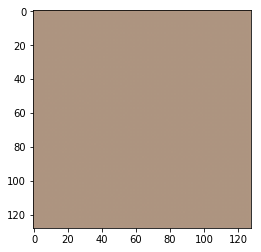

In [13]:
print(y.shape)
gen_imgs = denorm(y.squeeze(0).detach().cpu())
plt.imshow(gen_imgs.permute(1,2,0))

## Discriminatyor Training 
The discriminator is a binary classification model, we can use the binary crossentropy to use as a loss function. 
* If the image is real and you predict a high probability then you get a low loss! 

In this case we are not interested in what the digit contains. We are interested in whether it is real or fake. so labels for real images are all ones, and fake images are all 0s. we do a batch of real then a batch of fake ones.

`train_discriminator` does one step of training the discriminator, on a batch of images. 

In [14]:
criterion = nn.BCELoss()
d_opt = torch.optim.Adam(D.parameters(), lr = 0.0002)
g_opt = torch.optim.Adam(G.parameters(), lr = 0.0002)

In [15]:
def reset_grad():
    d_opt.zero_grad()
    g_opt.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    
    real_labels = torch.ones(images.shape[0], 1).to(device)
    fake_labels = torch.zeros(images.shape[0], 1).to(device)
    
    # loss for real images 
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)  # We expect the discriminator to output 1s
    real_score = outputs   # These are the probabilities
    
    # loss for fakeimages 
    z = torch.randn(batch_size, latent_size).to(device)  # We generate 100  latent vectors and move them to device
    fake_images = G(z)     # When we put the latent vectors into the generator, we get 100 fake images
    outputs = D(fake_images)   # The discriminator will hopefully think they are 0 
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs
    # Combine the losses 
    d_loss = d_loss_real+ d_loss_fake
    
    reset_grad()
    
    d_loss.backward()
    d_opt.step()
    
    return d_loss, real_score, fake_score
    
    
    
    

## Generator training

Since the output of the generators are vectors, which can be transformed to images, it is not obvious how we can train the generator. This is where we implement a very elegant **trick**. We do know the output images are generated or fake, we can pass them into the discriminator, and compare the output of the discriminator with the ground truth (i.e. all fake). We can then use this to calculate the loss for the genrator. 

We use the discriminator as part of the loss function.

We wish the discriminator to think all of the generated images are real, so labels of `[1,1,1,1,1...]` is desired. So, the loss function should be the cross entropy between the output and the desired labels, which is a list of ones.

In [16]:
z = torch.randn(batch_size, latent_size).to(device)
fake_images = G(z)
D(fake_images)

tensor([[0.5093],
        [0.5093],
        [0.5093],
        [0.5093],
        [0.5093],
        [0.5093],
        [0.5093],
        [0.5093],
        [0.5093],
        [0.5093],
        [0.5093],
        [0.5093],
        [0.5093],
        [0.5093],
        [0.5093],
        [0.5093],
        [0.5093],
        [0.5093],
        [0.5093],
        [0.5093],
        [0.5093],
        [0.5093],
        [0.5093],
        [0.5093],
        [0.5093],
        [0.5093],
        [0.5093],
        [0.5093],
        [0.5093],
        [0.5093]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [17]:
def train_generator():
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size,1).to(device)
    g_loss = criterion(D(fake_images),labels) # This is the binary cross entropy. We wish the discriminator to be fooled
    
    # backprop and optimize
    
    reset_grad()
    g_loss.backward()
    g_opt.step()
    return g_loss, fake_images

## Training! 

create the directory where we can save intermediate outputs to visually inspect the progress of the model 



In [18]:
import os 
sample_dir = 'fruitsamples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
    

In [19]:
from IPython.display import Image
from torchvision.utils import save_image

for images, _ in data_loader:
    images = images.reshape(images.size(0),3,128,128)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
    break

### Visualising the generated images before it is trained. 

In [20]:
G.load_state_dict(torch.load("gan_cnn1G.pth"))
D.load_state_dict(torch.load("gan_cnn1D.pth"))

sample_vectors = torch.randn(batch_size, latent_size).to(device)
print(batch_size, latent_size)
torch.cuda.empty_cache()
def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0),3,128,128)
    fake_fname= 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=5)
save_fake_images(2)
Image(os.path.join(sample_dir,'fake_images-0000.png'))
del fake_images


30 64
Saving fake_images-0002.png


In [21]:
def find_current_ite():
    current_ite = os.listdir(sample_dir)
    current_ite = [int(x[-8:-4]) for x in current_ite if "fake_images" in x]
    current_ite = max(current_ite)
    return current_ite

In [24]:
from tqdm import tqdm
num_epochs = 3
total_step = len(data_loader)
current = find_current_ite()
print(batch_size)
from tqdm import tqdm 
torch.cuda.empty_cache()
d_losses, g_losses, real_scores, fake_scores = [],[],[],[]
counter = 1
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # load a batch and transform to vectors 
        images = images.to(device)
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # inspect the losses 
        if (i+1) %200 ==0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print("Epoch %d / %d, step %d/%d, d_loss: %.4f, g_loss: %.4f, D(x): %.2f, D(g(z)): %.2f" %(epoch+1, num_epochs, i+1, total_step, 
                                                                                     d_loss, g_loss, real_score.mean(),
                                                                                                      fake_score.mean()))
            save_fake_images(counter+current)
            counter+=1

30
Epoch 1 / 3, step 200/2256, d_loss: 0.0000, g_loss: 13.2829, D(x): 1.00, D(g(z)): 0.00
Saving fake_images-0036.png
Epoch 1 / 3, step 400/2256, d_loss: 0.0000, g_loss: 13.3552, D(x): 1.00, D(g(z)): 0.00
Saving fake_images-0037.png
Epoch 1 / 3, step 600/2256, d_loss: 0.0000, g_loss: 12.8770, D(x): 1.00, D(g(z)): 0.00
Saving fake_images-0038.png
Epoch 1 / 3, step 800/2256, d_loss: 0.0000, g_loss: 13.1386, D(x): 1.00, D(g(z)): 0.00
Saving fake_images-0039.png
Epoch 1 / 3, step 1000/2256, d_loss: 0.0000, g_loss: 13.0953, D(x): 1.00, D(g(z)): 0.00
Saving fake_images-0040.png
Epoch 1 / 3, step 1200/2256, d_loss: 0.0000, g_loss: 13.4051, D(x): 1.00, D(g(z)): 0.00
Saving fake_images-0041.png
Epoch 1 / 3, step 1400/2256, d_loss: 0.0000, g_loss: 13.8196, D(x): 1.00, D(g(z)): 0.00
Saving fake_images-0042.png
Epoch 1 / 3, step 1600/2256, d_loss: 0.0000, g_loss: 14.0797, D(x): 1.00, D(g(z)): 0.00
Saving fake_images-0043.png
Epoch 1 / 3, step 1800/2256, d_loss: 0.0000, g_loss: 13.6104, D(x): 1.00,

In [ ]:
torch.save(D.state_dict(), "gan_cnn1D.pth")
torch.save(G.state_dict(), 'gan_cnn1G.pth')

## Visualising the results 

It will be nice to actually visualise the progress using a video. 

In [ ]:
import cv2 
import os 
from IPython.display.display import FileLink
vid_fname = 'gans_training.avi'
files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()
out = cv2.VideoWriter(vid_fname, cv2.VideoWriter_fourcc(*'MP4V'), 8, (782,652))  # 8 images per second. (302,302) is the combined size of the images
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')


In [37]:
#print(os.listdir(data_dir))
import shutil
import datetime


#os.mkdir(data_dir+"/all")
all_dir = data_dir+"/all"
for d in tqdm(os.listdir(data_dir)):
    if d != "all":
        fruitdir = data_dir+"/"+d
        imgs = os.listdir(data_dir+"/"+d)
        for img in imgs:
            imgdir = fruitdir+"/"+img
            now = str(datetime.datetime.now())[:19]
            now = now.replace(":","_")
            newdir = all_dir +"/"+ str(np.random.randint(10000000)) +".jpg"
            shutil.copy(imgdir,newdir)



  0%|                                                                                          | 0/133 [00:00<?, ?it/s]


TypeError: unsupported operand type(s) for &: 'str' and 'int'